Simulate cav1 MINFLUX tracks and run diffusion analysis on the resulting tracks.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
import os
import sys
sys.path.append("..")
from DiffusionAnalysis import DiffusionAnalysis

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

def f_msd(dt, D, sigma):
    dim = 2  # dimensions
    Rblur = 1/6.2  # blurring factor (MINFLUX)
    dtmean = 85.7e-6  # smallest (and median) dt between localizations
    return 2*dim*D*dt + 2*dim*sigma**2 - 4*dim*Rblur*D*dtmean

### PLOTTING PARAMS
%matplotlib inline

n_tracks_lim_incl = 20
n_tracks_lim_dapp = 5
fit_len_thresh = 15
n_tracks_lim_dtranscirc = 20
n_locs_dtrans = 50

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [18]:
%matplotlib agg
%matplotlib agg

# simulate data
N_rois = 5
N_pathsperroi = 250
N_meanlocsperpath = 200
N_siglocsperpath = 320

figures = [0]
# [site_rad, inclusion_rad, circle_radii, blob_dist, min_time, split_len_thresh, max_time_lag, max_dt, fit_len_thresh, meanslidestd_thresh, slidstd_interval, meanpos_thresh, interval_meanpos, interval_dist]
analysis_parameter_vals = [0.05, 0.05, [0.05,0.10,0.20], 0.013, 30e-3, 5, 500e-6, 1e-3, 10, 0.02, 40, 0.025, 5, 50]

analysis_sim_bidiff = DiffusionAnalysis('simulation_bidiff')
for fig in figures:
    analysis_sim_bidiff.create_fig(fig)
analysis_sim_bidiff.set_analysis_parameters(site_rad=analysis_parameter_vals[0], inclusion_rad=analysis_parameter_vals[1], circle_radii=analysis_parameter_vals[2],
                                 blob_dist=analysis_parameter_vals[3], min_time=analysis_parameter_vals[4], split_len_thresh=analysis_parameter_vals[5],
                                 max_time_lag=analysis_parameter_vals[6], max_dt=analysis_parameter_vals[7], fit_len_thresh=analysis_parameter_vals[8],
                                 meanslidestd_thresh=analysis_parameter_vals[9], slidstd_interval=analysis_parameter_vals[10],
                                 meanpos_thresh=analysis_parameter_vals[11], interval_meanpos=analysis_parameter_vals[12], interval_dist=analysis_parameter_vals[13])
analysis_sim_bidiff.simulate_data(N_rois=N_rois, N_paths=N_pathsperroi, N_locs=N_meanlocsperpath, N_locs_sg=N_siglocsperpath,
                           D=0.35, dt_set=100e-6, dt_random=True, w_n=9e-3,
                           imsize=0.5, imlimit=0.2, plotting=True, bidiffusional=True, D2=0.25, cav_site_rad=0.05, cut_outside_patt=True,
                           save_path=parentdir)
analysis_sim_bidiff.print_to_file_init()
analysis_sim_bidiff.diff_analysis()
analysis_sim_bidiff.msd_analysis(plot=False, binned=False, format='png', y_max=3.0, y_min=-1.0)
analysis_sim_bidiff.msd_analysis_per_track(format='png', y_max=3.0, y_min=-1.0)
analysis_sim_bidiff.msd_analysis_per_roi(format='png', y_max=3.0, y_min=-1.0)
analysis_sim_bidiff.msd_analysis()
analysis_sim_bidiff.print_to_file_close()

Simulated data added...


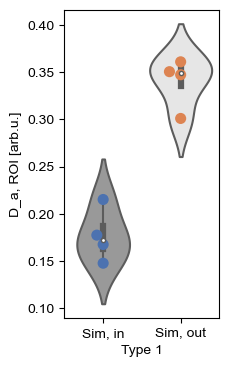

SM random in: 0.177 +- 0.012 µm^2/s
SM random out: 0.340 +- 0.012 µm^2/s
SM random
Ttest_indResult(statistic=-8.389711951835173, pvalue=0.0001561231971802599)


In [20]:
### SIMULATED DATA - DAPPs IN v OUT - VIOLIN + SWARM
%matplotlib inline

trackdata = analysis_sim_bidiff.track_data.copy()
dapps_all = []
confs = trackdata['confidx'].unique()
for conf in confs:
    conf_data = trackdata[trackdata['confidx']==conf].copy()
    rois = conf_data['roiidx'].unique()
    for roi in rois:
        roi_data = conf_data[conf_data['roiidx']==roi].copy()
        dapps_ins = []
        dapps_outs = []
        for _, row in roi_data.iterrows():
            if row['inout_flag'] == True:
                if len(row['dists_in']) > 0:
                    dists_in = row['dists_in']
                    dts_in = row['dts_in']
                    if len(dists_in) > fit_len_thresh:
                        x_fit = np.array([x for _, x in sorted(zip(dts_in, dists_in))])
                        t_fit = np.array([t for t, _ in sorted(zip(dts_in, dists_in))])
                        popt_msd, _ = curve_fit(f_msd, t_fit, x_fit)
                        dapps_ins.append(popt_msd[0])
                if len(row['dists_out']) > 0:
                    dists_out = row['dists_out']
                    dts_out = row['dts_out']
                    if len(dists_out) > fit_len_thresh:
                        x_fit = np.array([x for _, x in sorted(zip(dts_out, dists_out))])
                        t_fit = np.array([t for t, _ in sorted(zip(dts_out, dists_out))])
                        popt_msd, _ = curve_fit(f_msd, t_fit, x_fit)
                        dapps_outs.append(popt_msd[0])
        if len(dapps_ins) > n_tracks_lim_dapp and len(dapps_outs) > n_tracks_lim_dapp and np.mean(dapps_ins)>0 and np.mean(dapps_outs)>0:
            dapps_all.append(np.array([np.mean(dapps_ins),np.mean(dapps_outs)]))
                

dapps_in = [dapps[0] for dapps in dapps_all]
dapps_out = [dapps[1] for dapps in dapps_all]
dapps_in = np.array([rat for rat in dapps_in if rat==rat])
dapps_out = np.array([rat for rat in dapps_out if rat==rat])
datain = {'Type 1': ['Sim, in'] * len(dapps_in),
                'Total': np.array(dapps_in)}
dataout = {'Type 1': ['Sim, out'] * len(dapps_out),
                'Total': np.array(dapps_out)}
df = pd.concat([pd.DataFrame(d) for d in [datain, dataout]], ignore_index=True)

# plot
fig = plt.figure(figsize=(2, 4))
my_palette = {'Sim, in': (0.6,0.6,0.6), 'Sim, out': (0.9,0.9,0.9)}
sns.swarmplot(x='Type 1', y='Total', data=df, size=8, alpha=1.0, palette="deep")
sns.violinplot(x='Type 1', y='Total', data=df, inner='box', palette=my_palette)
plt.ylabel('D_a, ROI [arb.u.]')
plt.show()

print(f'SM random in: {np.mean(dapps_in):.3f} +- {np.std(dapps_in)/np.sqrt(len(dapps_in)):.3f} µm^2/s')
print(f'SM random out: {np.mean(dapps_out):.3f} +- {np.std(dapps_out)/np.sqrt(len(dapps_out)):.3f} µm^2/s')
result_rois = scipy.stats.ttest_ind(dapps_in, dapps_out)
print('SM random')
print(result_rois)

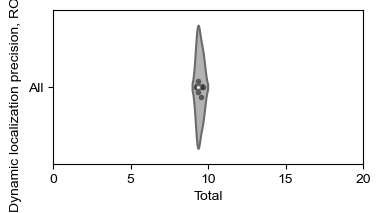

All comb: 9.431 +- 0.074 nm


In [21]:
### SIMULATED DATA - LOC. PREC DAPP FIT - VIOLIN + SWARM
%matplotlib inline

trackdata = analysis_sim_bidiff.track_data.copy()
locprec = []
confs = trackdata['confidx'].unique()
for conf in confs:
    conf_data = trackdata[trackdata['confidx']==conf].copy()
    rois = conf_data['roiidx'].unique()
    for roi in rois:
        roi_data = conf_data[conf_data['roiidx']==roi].copy()
        locprecs = []
        for _, row in roi_data.iterrows():
            if row['inout_flag'] == True:
                if len(row['dists_in']) > 0 or len(row['dists_out']):
                    dists = np.concatenate([row['dists_in'], row['dists_out']])
                    dts = np.concatenate([row['dts_in'], row['dts_out']])
                    if len(dists) > fit_len_thresh:
                        x_fit = np.array([x for _, x in sorted(zip(dts, dists))])
                        t_fit = np.array([t for t, _ in sorted(zip(dts, dists))])
                        popt_msd, _ = curve_fit(f_msd, t_fit, x_fit)
                        locprecs.append(popt_msd[1])
        if len(locprecs) > n_tracks_lim_dapp and np.mean(locprecs)>0:
            locprec.append(np.array([np.mean(locprecs)]))
locprec_all = np.concatenate(locprec)
locprecs = [locprec*1000 for locprec in locprec_all]
locprecs = np.array([locprec for locprec in locprecs if locprec==locprec])
dataall = {'Type 1': ['All'] * len(locprecs),
         'Total': np.array(locprecs)}
df_all = pd.concat([pd.DataFrame(d) for d in [dataall]], ignore_index=True)

# plot
fig = plt.figure(figsize=(4, 2))
my_palette = {'All': (0.7,0.7,0.7)}
sns.swarmplot(y='Type 1', x='Total', data=df_all, color='#000000', size=4, alpha=0.5)
sns.violinplot(y='Type 1', x='Total', data=df_all, inner='box', palette=my_palette)
plt.ylabel('Dynamic localization precision, ROI [nm]')
plt.xlim(0,20)
plt.show()

print(f'All comb: {np.mean(locprecs):.3f} +- {np.std(locprecs)/np.sqrt(len(locprecs)):.3f} nm')